# Abstract dataset, dataloaders using fastai

In [ ]:
#| default_exp nb_04b_data

## Load df

In [ ]:
import torch

In [ ]:
torch.version.cuda

'11.6'

In [ ]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

[<torch.cuda.device>, <torch.cuda.device>]

In [ ]:
 torch.cuda.device_count()

2

In [ ]:
torch.cuda.current_device()

0

In [ ]:
from fastai.vision.all import *

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [ ]:
fs= (20,10)

In [ ]:
from pathlib import Path

In [ ]:
p_outx = Path("/media/dimi/TOSHIBA EXT/patched_images")
p_outy = Path("/media/dimi/TOSHIBA EXT/patched_masks")

In [ ]:
df = pd.read_pickle("data/df_all_2022_10_06.pkl")
df.reset_index
df.loc[df["G"]=="2", "G"] = 2
df = df.loc[df["G"]!="1,2"]

In [ ]:
df.G = df.G.astype("int")

In [ ]:
weights = df.G.value_counts()/df.shape[0]
weights.tolist()

[0.8343245539507221, 0.1070518266779949, 0.05862361937128292]

In [ ]:
def split_df(df, η=0.8 # percentage training
            ):
    msk = np.random.rand(len(df)) < η
    return df[msk], df[~msk]

In [ ]:
#df_sampled = df.sample(n=100)
df_train, df_valid = split_df(df)

In [ ]:
df_train.shape, df_valid.shape

((948, 95), (229, 95))

In [ ]:
from fastai.vision.all import *

In [ ]:
from torchvision import datasets, transforms

In [ ]:
import PIL

In [ ]:
#|export
from ml.nb_03_dataset import *

## Dataset and dataloaders

In [ ]:
def open_patch(fname, size=None):
    img = PIL.Image.open(fname).convert('RGB')
    if size is not None: img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

In [ ]:
class PatchedImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        images, target = self 
        if not isinstance(images[0], Tensor):
            tensors = [tensor(im).permute(2,0,1) for im in images]
        else: tensors = images
        line = tensors[0].new_zeros(tensors[0].shape[0], tensors[0].shape[1], 5)
        ts = [tensors[0]]+[torch.cat([line, t], dim=2) for t in tensors[1:]]
        return show_image(torch.cat(ts, dim=2), title=target, ctx=ctx, **kwargs)

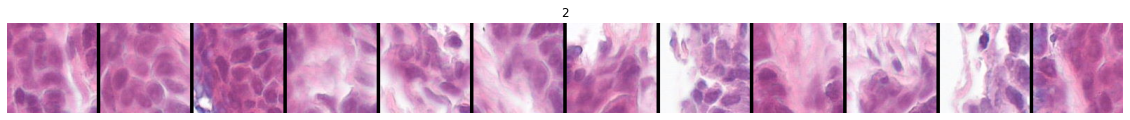

In [ ]:
images_path = p_outx.str()+"/"+df.TMA_ID+"_"+df.TMASpot
image_path=images_path[0]

patch_paths = [image_path+"_"+str(i)+".png" for i in range(12)]

y = df.iloc[0]["G"]

images = [PILImage.create(p) for p in patch_paths]

s = PatchedImage(images, y)

s.show(figsize=(20,5));

In [ ]:
#| export
class PatchedTransform(Transform):

    """Returns a batch of N patches with the specified target in dataframe"""
    
    def __init__(self, 
                 img_path, # Path with images   
                 df, # pandas dataframe
                 y_col, # df column for target
                 stime_col, #df column with survival time
                 N, # number of patches
                 mean, #mean for normalization
                 std,  #std for normalization
                 trfms=None #list of transforms
                ):
        self.img_path = img_path
        self.df = df
        self.df.reset_index()
        self.y_col = y_col
        self.stime_col = stime_col
        self.N = N
        self.mean, self.std = mean, std
        self.trfms = trfms
        self.img_ids = self.get_img_ids()
        
    def get_img_ids(self):
        col = self.img_path.str()+"/"+self.df.TMA_ID+"_"+self.df.TMASpot
        return col.tolist()
                
        
    def encodes(self, idx):
        img_id = self.img_ids[idx]
        y = self.df.iloc[idx][self.y_col]
        patch_paths = [img_id+"_"+str(i)+".png" for i in range(self.N)]
        patches = []
        
        
        
        for p in patch_paths:
            #img = PILImage.create(p)
            img = open_patch(p)
            
            if self.trfms is not None: 
                trnfs = torch.nn.Sequential(*self.trfms)
                img = trnfs(img)

            patches.append(img)
            
        #patches = torch.stack(patches, dim=0)
        
        return PatchedImage(patches,torch.LongTensor([y]).squeeze())
    #(TensorImage(patches), torch.Tensor([y]).squeeze())

In [ ]:
train_tl= TfmdLists(range(len(df_train)), PatchedTransform(p_outx,df_train,"G","stime_10y_dom",12,mean_img,std_img ))
valid_tl= TfmdLists(range(len(df_valid)), PatchedTransform(p_outx,df_valid,"G","stime_10y_dom",12,mean_img,std_img ))

In [ ]:
#train_tl= TfmdLists(range(len(df_train)), PatchedTransform(p_outx,df_train,"G","stime_10y_dom",12,\
#            mean_img,std_img, trfms= [transforms.Normalize(mean_img, std_img)]))

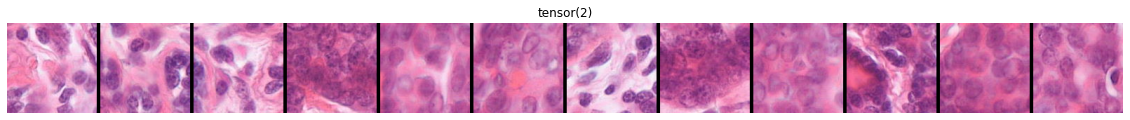

In [ ]:
show_at(train_tl,0, figsize=fs);

In [ ]:
dls = train_tl.dataloaders(bs=4)

In [ ]:
@typedispatch
def show_batch(x:PatchedImage, y, samples, ctxs=None, max_n=12, nrows=None, ncols=1, figsize=None, **kwargs):
    x1 = torch.cat(x[0])
    x2 = x[1]
    x1 = x1.view(x2.shape[0],-1, x1.shape[1],x1.shape[2],x1.shape[3])
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(x[0][0].shape[0], nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): PatchedImage(x1[i], x2[i].item()).show(ctx=ctx)

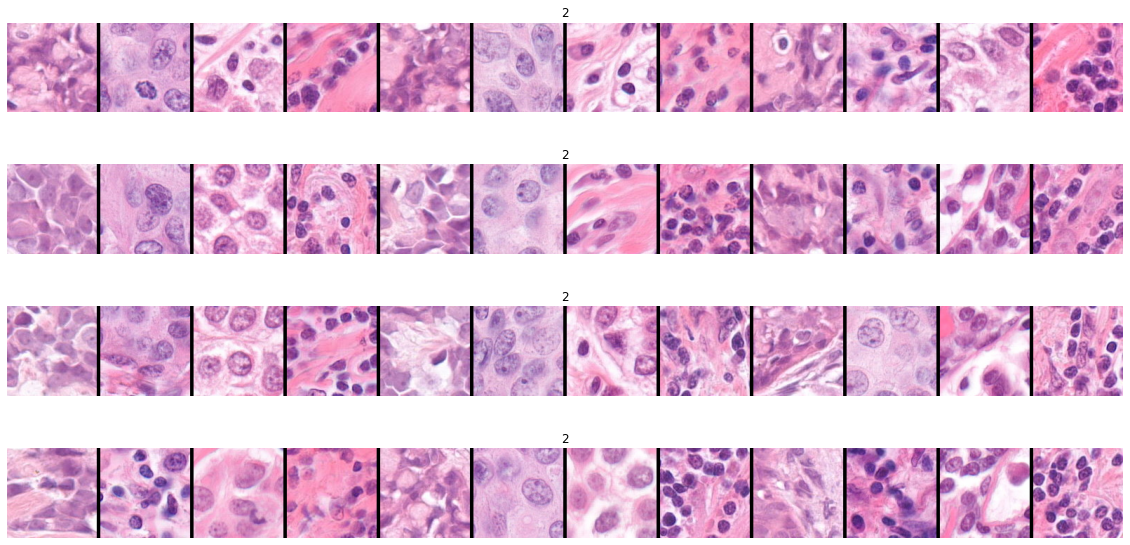

In [ ]:
dls.show_batch(figsize=fs)

## Model

In [ ]:
from torch import nn

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`"
    def __init__(self, size=None):
        super(AdaptiveConcatPool2d, self).__init__()
        self.size = size or 1
        self.ap = nn.AdaptiveAvgPool2d(self.size)
        self.mp = nn.AdaptiveMaxPool2d(self.size)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, arch='resnext50_32x4d_ssl', n=3, pre=True):
        super().__init__()
        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', arch)
        self.enc = nn.Sequential(*list(m.children())[:-2])       
        nc = list(m.children())[-1].in_features
        self.head = nn.Sequential(AdaptiveConcatPool2d(),nn.Flatten(),nn.Linear(2*nc,512),
                            nn.Mish(),nn.BatchNorm1d(512), nn.Dropout(0.5),nn.Linear(512,n))

    def forward(self, *x):
        N, bs = len(x[0]), x[0][0].shape[0]
        x = torch.cat(x[0])
        x = x.view(bs,N, x.shape[1],x.shape[2],x.shape[3])
        shape = x.shape  #4, 12, 3, 128, 128
        bs, N, c, sz_x, sz_y = shape[0], shape[1], shape[2], shape[3], shape[4]
        x = x.view(-1, c, sz_x, sz_y)
        x = self.enc(x) #x: bs*N x C x 4 x 4
        shape = x.shape 
        x = x.view(-1,N,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous()\
             .view(bs,shape[1],shape[2]*N,shape[3])  #x: bs x C x N*4 x 4
        x = self.head(x) #x: bs x N
        return x

In [ ]:
model = NeuralNetwork().to(device)

Using cache found in /home/dimi/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
learn = Learner(dls, model= model, loss_func=loss_fn, metrics=accuracy)
#learn.model = learn.model.cpu()

NameError: name 'dls' is not defined

In [ ]:
# CUDA_LAUNCH_BLOCKING=1.

In [ ]:
#learn.lr_find()

## Tuples

In [ ]:
df = df_train
df.shape

(948, 95)

In [ ]:
df.G.value_counts()

2    790
1     99
3     59
Name: G, dtype: int64

In [ ]:
files = df.fn_x.tolist()

In [ ]:
# files[:5]

In [ ]:
files[0]

Path('/media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA01_correctNames_SingleCores/2-D.tif')

In [ ]:
def file2patches(f):
    #if f is not Path: f = Path(f)
    tmp = df[df.fn_x==f]
    image_path = p_outx.str()+"/"+tmp.TMA_ID+"_"+tmp.TMASpot
    return [image_path.item()+"_"+str(i)+".png" for i in range(12)]

In [ ]:
file2patches(files[0])

['/media/dimi/TOSHIBA EXT/patched_images/TMA1_D02_0.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_D02_1.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_D02_2.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_D02_3.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_D02_4.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_D02_5.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_D02_6.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_D02_7.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_D02_8.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_D02_9.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_D02_10.png',
 '/media/dimi/TOSHIBA EXT/patched_images/TMA1_D02_11.png']

In [ ]:
def file2y(f):
    return int(df[df.fn_x==f]["G"].item())

In [ ]:
file2y(files[0])

2

In [ ]:
def open_patch(fname, size=None):
    img = PIL.Image.open(fname).convert('RGB')
    if size is not None: img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0 #(3,128,128)

In [ ]:
def topatch(fn): 
    pts = file2patches(fn)
    x1 = torch.cat([open_patch(f) for f in pts[:4]], dim=2)
    x2 = torch.cat([open_patch(f) for f in pts[4:8]], dim=2)
    x3 = torch.cat([open_patch(f) for f in pts[8:]], dim=2)
    return TensorImage(torch.cat([x1,x2,x3], dim=1).unsqueeze(0) )#(1, 3, 384, 512)

In [ ]:
#def topatch(fn): 
#    pts = file2patches(fn)
#    x = torch.stack([open_patch(f) for f in pts], dim=0)
#    #print(x.shape)
#    return TensorImage(x)

In [ ]:
class PatchTuple(fastuple):
    @classmethod
    def create(cls, fn): 
        return cls(tuple(topatch(fn)))
    
    def send(fn): return topatch(fn)
     
    def show(self, ctx=None, **kwargs):
        image = self[0] 
        if not isinstance(image, Tensor):
            t = [tensor(im).permute(2,0,1)/255. for im in images]
        else: t = image
        return show_image(t, ctx=ctx, **kwargs)

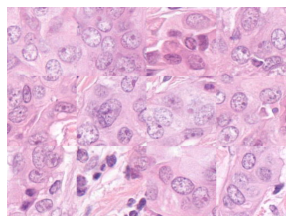

In [ ]:
img = PatchTuple.create(files[0])
img.show(figsize=(5,5));

In [ ]:
#show_image(open_patch(files[0]))

In [ ]:
def PatchTupleBlock(): return TransformBlock(type_tfms=PatchTuple.send, batch_tfms=IntToFloatTensor)

In [ ]:
files = L(files)

In [ ]:
splits = RandomSplitter()(files)

In [ ]:
splits_files = [files[splits[i]] for i in range(2)]
splits_sets = mapped(set, splits_files)

In [ ]:
def get_split(f):
    for i,s in enumerate(splits_sets):
        if f in s: return i
    raise ValueError(f'File {f} is not presented in any split.')

In [ ]:
def splitter(items): 
    def get_split_files(i): return [j for j,f in enumerate(items) if get_split(f)==i]
    return get_split_files(0),get_split_files(1)

In [ ]:
# def get_tuples(files): return [[f, file2y(f)] for f in files]

In [ ]:
def get_tuples(files): return files# [[f, file2y(f)] for f in files]

In [ ]:
#def get_split_files(i): return [j for j,(f,y) in enumerate(items) if get_split(f)==i]

In [ ]:
#filesl = [str(f) for f in files]

In [ ]:
tt= get_tuples(files)

In [ ]:
tt[0]

Path('/media/dimi/TOSHIBA EXT/Dimitrij Original Images/TMA01_correctNames_SingleCores/2-D.tif')

In [ ]:
def get_x(t): return t
def get_y(t): return file2y(t)# t[1]

In [ ]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [ ]:
img_stats = (mean_img, std_img)

In [ ]:
@typedispatch
def show_batch(x:PatchTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

In [ ]:
#dls.show_batch()

In [ ]:
# b = dls.one_batch()
#explode_types(b)

In [ ]:
# xb, yb = first(dls.train)

In [ ]:
# print(xb.shape, yb.shape)

In [ ]:
## Define model
#class NeuralNetwork(nn.Module):
#    def __init__(self, arch='resnext50_32x4d_ssl', n=3, pretrained=True):
#        super().__init__()
#        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', arch)
#        self.enc = nn.Sequential(*list(m.children())[:-2])       
#        nc = list(m.children())[-1].in_features
#        self.head = nn.Sequential(AdaptiveConcatPool2d(),nn.Flatten(),nn.Linear(2*nc,512),
#                            nn.Mish(),nn.BatchNorm1d(512), nn.Dropout(0.5),nn.Linear(512,n))
#
#    def forward(self, *x):
#        #N, bs = len(x[0]), x[0][0].shape[0]
#        #x = torch.cat(x[0])
#        #x = x.view(bs,N, x.shape[1],x.shape[2],x.shape[3])
#        x = x[0]
#        shape = x.shape  #4, 12, 3, 128, 128
#        bs, N, c, sz_x, sz_y = shape[0], shape[1], shape[2], shape[3], shape[4]
#        x = x.view(-1, c, sz_x, sz_y)
#        x = self.enc(x) #x: bs*N x C x 4 x 4
#        shape = x.shape 
#        x = x.view(-1,N,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous()\
#             .view(bs,shape[1],shape[2]*N,shape[3])  #x: bs x C x N*4 x 4
#        x = self.head(x) #x: bs x N
#        return x

In [ ]:
from fastai.data.block import _apply_pipeline

In [ ]:
from tqdm import tqdm as tqdm

In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa = skm_to_fastai(cohen_kappa_score)

In [ ]:
patches = DataBlock(
    blocks=(PatchTupleBlock, CategoryBlock),
    get_items=get_tuples,
    get_x=get_x, 
    get_y=get_y,
    splitter=splitter,
    item_tfms = [torch.squeeze,  RandomCrop(64), 
                # FlipItem
                ],
    batch_tfms=[IntToFloatTensor, Normalize
                #Normalize.from_stats(*imagenet_stats)
               ]
)

In [ ]:
dls = patches.dataloaders(files, batch_size=16)

In [ ]:
#class DiceLoss(nn.Module):
#    def __init__(self, weight=None, size_average=True):
#        super(DiceLoss, self).__init__()
# 
#    def forward(self, inputs, targets, smooth=1):        
#        inputs = inputs.argmax(dim=1).add(1)
#        print(inputs.shape, targets.shape)
#        
#        inputs = F.sigmoid(inputs)       
#        
#        inputs = inputs.view(-1)
#        targets = targets.view(-1)
#        
#        intersection = (inputs * targets).sum()                            
#        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
#        
#        return 1 - dice

In [ ]:
from sklearn.utils import class_weight

In [ ]:
y = df.G.to_numpy()

In [ ]:
class_weights=class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

In [ ]:
class_weights=torch.tensor(class_weights,dtype=torch.float)

In [ ]:
np.unique(y)

array([1, 2, 3])

In [ ]:
class_weights

tensor([3.1919, 0.4000, 5.3559])

In [ ]:
lf = nn.CrossEntropyLoss(weight=class_weights,reduction='mean')

In [ ]:
learn = vision_learner(dls, resnet50, metrics=[accuracy, kappa], pretrained=True, opt_func=ranger, loss_func=lf)
# learn = Learner(dls, m, metrics=[accuracy, kappa])

/home/dimi/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dimi/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0020892962347716093)

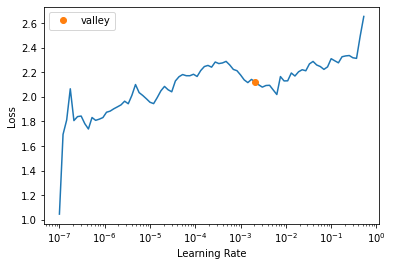

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 0.002)

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time


KeyboardInterrupt: 

In [ ]:
learn.fine_tune(8, 0.002)

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,0.305253,0.845789,0.687831,0.203045,00:08


epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,0.324790,0.676525,0.708995,0.279476,00:10
1,0.424754,0.735934,0.708995,0.230057,00:10
2,0.468081,0.875685,0.730159,0.268443,00:10
3,0.469535,0.968531,0.740741,0.226703,00:10
4,0.407238,0.771601,0.767196,0.227640,00:10
5,0.268844,0.740340,0.756614,0.213711,00:10
6,0.194457,0.683206,0.751323,0.254782,00:09
7,0.177030,0.694035,0.761905,0.249073,00:10


In [ ]:
learn.fit_one_cycle(4, 0.019)

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,1.863524,0.778594,0.774869,-0.066346,00:09
1,1.258791,0.778333,0.753927,0.202965,00:08
2,0.833007,0.495506,0.811518,0.238960,00:09
3,0.549482,0.509477,0.821990,0.226997,00:09


In [ ]:
learn.fit_one_cycle(40, 0.019)

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,1.877116,0.861324,0.554974,0.014448,00:09
1,1.617873,1.377564,0.518325,0.121488,00:08
2,1.290217,1.012104,0.602094,0.070976,00:09
3,1.016357,0.535796,0.832461,0.233605,00:09
4,0.817796,0.693398,0.827225,0.211829,00:08
5,0.735596,0.882965,0.654450,0.249688,00:08
6,0.744271,7.942821,0.198953,0.037609,00:08
7,0.739788,0.877617,0.675393,0.151172,00:08
8,0.788676,0.526117,0.785340,0.316010,00:08
9,0.765302,0.738237,0.717277,0.023665,00:08


KeyboardInterrupt: 